In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.auto import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# EDA

In [2]:
TRAIN_CSV_PATH = "../input/nornickel-ore-contamination-detection/data/train.csv"
TRAIN_CSV_ENCODED_PATH = "../input/nornickel-ore-contamination-detection/data/train_encoded.csv"
IMAGES_PATH = "../input/nornickel-ore-contamination-detection/data/images/images/"
SAMPLE_SUBMISSION_PATH = "../input/nornickel-ore-contamination-detection/data/sampleSubmission.csv"

In [3]:
data = pd.read_csv(TRAIN_CSV_PATH)
train_encoded = pd.read_csv(TRAIN_CSV_ENCODED_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

In [4]:
data.head(5)

,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax
0,0,0007Date_01_08_2019.jpg,other,285,368,61,278
1,1,0013Date_01_08_2019.jpg,armature,187,550,101,253
2,2,0016Date_01_08_2019.jpg,armature,172,327,13,360
3,3,0019Date_01_08_2019.jpg,armature,19,267,162,237
4,4,0019Date_01_08_2019.jpg,armature,309,548,300,376


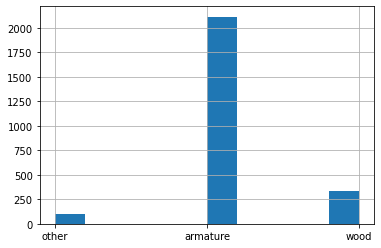

In [5]:
data.type.hist()
plt.show()

In [6]:
def get_config(data):
    config = dict()
    type_ids = {'wood': 1, 'armature': 2, 'other': 3}
    data = data.to_numpy()
    for x in data:
        k = config.get(x[1], None)
        if k:
            config[x[1]]['label'].append(type_ids[x[2]])
            x_min, x_max, y_min, y_max = x[3:].tolist()
            config[x[1]]['box'].append([x_min, y_min, x_max, y_max])
        else:
            x_min, x_max, y_min, y_max = x[3:].tolist()
            config[x[1]] = {'label': [type_ids[x[2]]], 'box': [[x_min, y_min, x_max, y_max]]}
    return config

config = get_config(data)

In [7]:
train_data, val_data = train_test_split(np.array([list(config.keys()), list(config.values())]).T, test_size=0.05, random_state=32)

In [8]:
train_data[0]

array(['9080Date_04_08_2019.jpg',
       {'label': [2], 'box': [[281, 85, 618, 421]]}], dtype=object)

# Dataset

In [9]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.type_ids = {'wood': 1, 'armature': 2, 'other': 3}
        self.transform = transform
        self.image_names = []
        self.labels = []
        self.boxes = []
        for filename, item in data:
            self.image_names.append(filename)
            self.labels.append(item['label'])
            self.boxes.append(item['box'])
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        sample = dict()
        image_name = IMAGES_PATH + self.image_names[idx]
        image = cv2.imread(image_name, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        sample['labels'] = torch.LongTensor(label)
        boxes = self.boxes[idx]
        sample['boxes'] = torch.tensor(boxes)
        if self.transform:
            transformed = self.transform(image=image, boxes=boxes, class_labels=label)
            image = transformed['image']
            sample['boxes'] = torch.tensor([list(map(int, box)) for box in transformed['bboxes']])
            sample['labels'] = torch.LongTensor(transformed['class_labels'])
        sample['masks'] = self.build_masks(sample['boxes'], image)
        return image, sample
    
    def ids2type(self, ids):
        id2type = {v: k for k, v in self.type_ids.items()}
        types = []
        for id_ in ids:
            types.append(id2type[id_])
        return types
    
    def show_image(self, image, figsize=(16, 9), reverse=True):
        plt.figure(figsize=figsize)
        if reverse:
            plt.imshow(image[..., ::-1])
        else:
            plt.imshow(image)
        plt.axis('off')
        plt.show()
    
    def visualize_from_dataset(self, idx):
        filename = IMAGES_PATH + self.image_names[idx]
        img = cv2.imread(filename, cv2.COLOR_BGR2RGB)
        boxes = self.boxes[idx]
        print(self.ids2type(self.labels[idx]))
        for i in range(len(boxes)):
            x_min, y_min, x_max, y_max = boxes[i]
            image = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        self.show_image(image)
    
    def visualize_transforms(self, idx):
        img, item = self.__getitem__(idx)
        image = img.permute(1, 2, 0).numpy().copy()
        boxes = item['boxes'].numpy().copy()
        print(self.ids2type(item['labels'].numpy().copy()))
        for i in range(len(boxes)):
            x_min, y_min, x_max, y_max = boxes[i]
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        self.show_image(image)
        
    def visualize_masks(self, idx):
        img, item = self.__getitem__(idx)
        image = img.permute(1, 2, 0).numpy().copy()
        boxes = item['boxes'].numpy().copy()
        for box in boxes:
            if type(image) == torch.Tensor:
                mask = np.zeros(shape=image.shape[1:], dtype=np.uint8)
            else:
                mask = np.zeros(shape=image.shape[:2], dtype=np.uint8)
            x_min, y_min, x_max, y_max = box
            image = cv2.fillConvexPoly(image, np.array([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]]), 1)
        self.show_image(image)
        
    @staticmethod
    def build_masks(raw_boxes, image):
        masks = []
        for box in raw_boxes:
            if type(image) == torch.Tensor:
                mask = np.zeros(shape=image.shape[1:], dtype=np.uint8)
            else:
                mask = np.zeros(shape=image.shape[:2], dtype=np.uint8)
            x_min, y_min, x_max, y_max = box.numpy()
            cv2.fillConvexPoly(
                mask, 
                np.array([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]]), 
                1
            )
            masks.append(torch.tensor(mask))
        return torch.stack(masks)

In [10]:
alb_transforms = A.Compose([
    A.augmentations.transforms.Flip(),
    A.augmentations.transforms.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=False, p=0.2),
    A.augmentations.transforms.GaussianBlur(blur_limit=(3, 5), p=0.1),
    A.augmentations.transforms.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def train_transforms(transform=alb_transforms, **kwargs):
    image = kwargs.get("image")
    bboxes = kwargs.get("boxes")
    class_labels = kwargs.get("class_labels")
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed["image"]
    transformed_boxes = transformed["bboxes"]
    transformed_labels = transformed["class_labels"]
    transformed_image = transforms.ToTensor()(transformed_image)
    return {"image": transformed_image, "bboxes": transformed_boxes, "class_labels": transformed_labels}

val_alb_transforms = A.Compose([
    A.augmentations.transforms.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=1.0),
])

def val_transforms(transform=val_alb_transforms, **kwargs):
    image = kwargs.get("image")
    bboxes = kwargs.get("boxes")
    class_labels = kwargs.get("class_labels")
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed["image"]
    transformed_boxes = transformed["bboxes"]
    transformed_labels = transformed["class_labels"]
    transformed_image = transforms.ToTensor()(transformed_image)
    return {"image": transformed_image, "bboxes": transformed_boxes, "class_labels": transformed_labels}

train_dataset = ImageDataset(train_data, train_transforms)
val_dataset = ImageDataset(val_data, val_transforms)

In [11]:
# duplicate wood and other images
image_names, boxes, labels = [], [], []
for i in range(5):
    for image_name, box, label in zip(train_dataset.image_names, train_dataset.boxes, train_dataset.labels):
        if (1 in label) or (3 in label):
            image_names.append(image_name)
            boxes.append(box)
            labels.append(label)

In [12]:
for image_name, box, label in zip(image_names, boxes, labels):
    train_dataset.image_names.append(image_name)
    train_dataset.boxes.append(box)
    train_dataset.labels.append(label)

['armature']


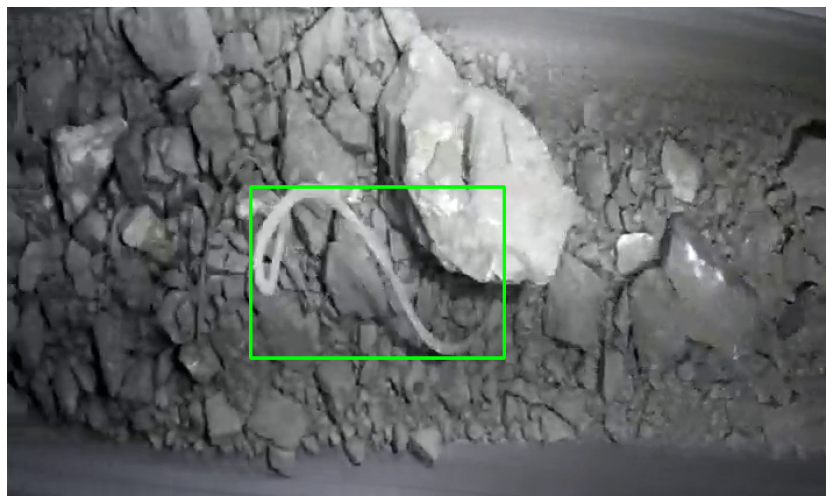

['armature']


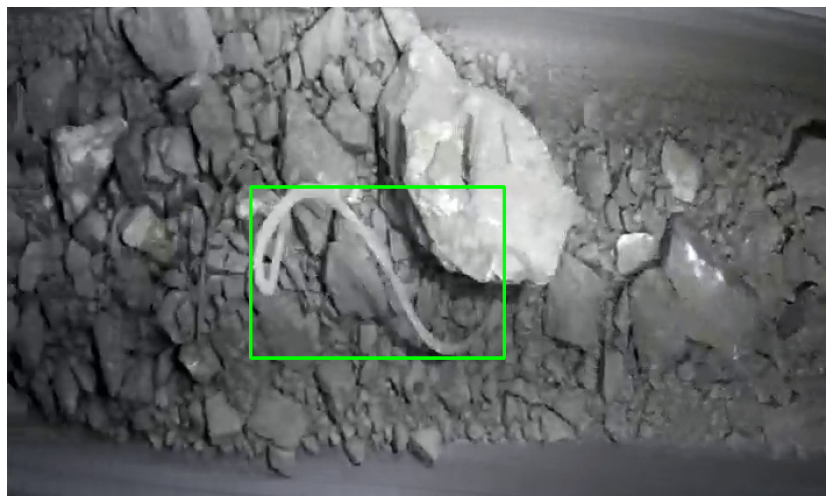

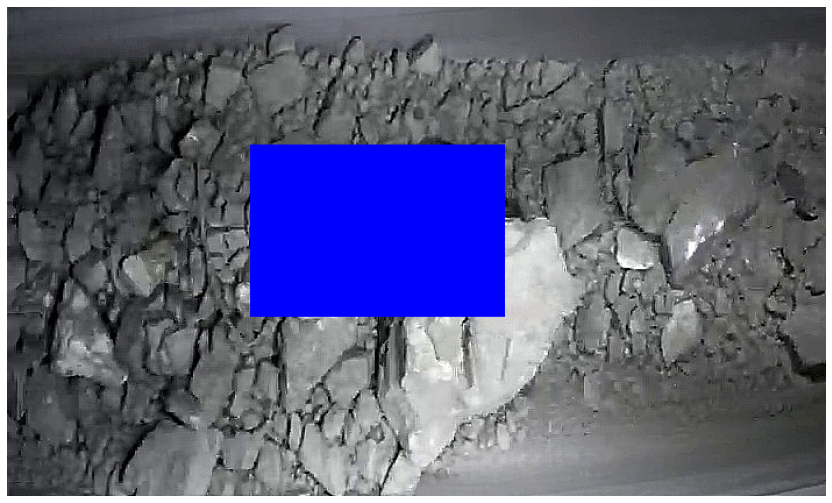

In [13]:
idx = 777
train_dataset.visualize_from_dataset(i)
train_dataset.visualize_transforms(i)
train_dataset.visualize_masks(i)

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(
    train_dataset, batch_size=8, 
    shuffle=True, num_workers=1, 
    drop_last=True, pin_memory=True, 
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    val_dataset, batch_size=8, 
    shuffle=False, num_workers=1, 
    drop_last=False, pin_memory=True, 
    collate_fn=collate_fn
)

In [15]:
from collections import Counter

train_counter = Counter()
for label in train_dataset.labels:
    for l in label:
        train_counter[l] += 1
        
val_counter = Counter()
for label in val_dataset.labels:
    for l in label:
        val_counter[l] += 1

print("train count:", train_counter)
print("val count:", val_counter)

train count: Counter({2: 2318, 1: 1842, 3: 546})
val count: Counter({2: 100, 1: 23, 3: 7})


# Training model

In [16]:
def create_maskrcnn_model():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        pretrained_backbone=True,
        rpn_anchor_generator=None,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
    )
    num_classes = 4  # 3 classes + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = create_maskrcnn_model()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [18]:
# model.load_state_dict(torch.load("../input/nornickel-models/MaskRCNN_no_add_data_change_labels_best.pth", map_location=device))

In [19]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [20]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=5e-3,
    momentum=0.9, weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=2,
    verbose=False, threshold=1e-3
)

In [21]:
def train_one_epoch(model, dataloader, optimizer, device='cpu'):
    train_losses = []
    for images, items in tqdm(dataloader):
        img = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in items]
        predicted_dict = model(img, targets)
        losses = sum(loss for loss in predicted_dict.values())
        train_losses.append(losses.cpu().item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return train_losses

def evaluate(model, dataloader, device='cpu'):
    eval_losses = []
    with torch.no_grad():
        for images, items in tqdm(dataloader):
            img = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in items]
            loss_dict = model(img, targets)
            losses = sum(loss for loss in loss_dict.values())

            eval_losses.append(losses.cpu().item())
    return eval_losses

In [22]:
best_val = np.inf

epochs = 17
model.train()
model.to(device)
for i in tqdm(range(epochs)):
    # train
    train_losses = train_one_epoch(model, train_dataloader, optimizer, device)
    train_loss = np.mean(train_losses)
    tqdm.write(f"Epoch {i}: train_loss = {train_loss}")
    
    # eval 
    eval_losses = evaluate(model, val_dataloader, device)
    eval_loss = np.mean(eval_losses)
    tqdm.write(f"valid_loss = {eval_loss}")
    
    # save best model
    if eval_loss < best_val:
        best_val = eval_loss
        torch.save(model.state_dict(), "best_model.pth")
    
    lr_scheduler.step(eval_loss)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch 0: train_loss = 0.4605072185993195


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3774704813957214


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: train_loss = 0.3214136636853218


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3348797639211019


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2: train_loss = 0.27810018852353097


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3396912078062693


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3: train_loss = 0.2520803119540215


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3395242313543955


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4: train_loss = 0.2301101941615343


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.32248905102411907


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5: train_loss = 0.21656016233563424


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.31798261602719624


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6: train_loss = 0.20522992847859858


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3132215917110443


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7: train_loss = 0.19842904150485993


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.32400074501832327


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8: train_loss = 0.1928981014341116


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3252264648675919


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9: train_loss = 0.18292062138020992


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3224032501379649


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10: train_loss = 0.1600749640762806


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3072232921918233


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11: train_loss = 0.1531148996055126


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.31500076949596406


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12: train_loss = 0.1497227169275284


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.31654373904069266


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13: train_loss = 0.14780834954977035


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3175452162822088


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14: train_loss = 0.145580526933074


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.31630210181077323


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15: train_loss = 0.14429072773456572


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3148353725671768


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16: train_loss = 0.14375177671015263


  0%|          | 0/15 [00:00<?, ?it/s]

valid_loss = 0.3177963227033615


In [23]:
torch.save(model.state_dict(), "final_model.pth")

# Make submission

In [24]:
class TestImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.type_ids = {'wood': 1, 'armature': 2, 'other': 3}
        self.transform = transform
        image_names = data['Image_name_Type'].tolist()
        self.image_names = [
            '_'.join(image_names[i].split('_')[:-1]) for i in range(0, len(image_names), 3)
        ]
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        sample = dict()
        sample["image_name"] = self.image_names[idx]
        image_path = IMAGES_PATH + self.image_names[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, sample

In [25]:
def test_transforms(transform=val_alb_transforms, **kwargs):
    image = kwargs.get("image")
    image = transform(image=image)["image"]
    image = transforms.ToTensor()(image)
    return {"image": image}

test_dataset = TestImageDataset(sample_submission, test_transforms)

test_dataloader = DataLoader(
    test_dataset, batch_size=8,
    num_workers=1, pin_memory=True,
    shuffle=False, drop_last=False,
    collate_fn=collate_fn
)

In [26]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
# model.load_state_dict(torch.load("../input/nornickel-models/MaskRCNN_no_add_data_change_labels_best.pth", map_location=device))

<All keys matched successfully>

In [27]:
def visualize(name, boxes):
    plt.figure(figsize=(16, 8))
    filename = IMAGES_PATH + name
    img = cv2.imread(filename, cv2.COLOR_BGR2RGB)
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        image = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()


In [28]:
def get_pred_boxes(model, dataloader, threshhold=0.8, device='cpu'):
    model.to(device)
    model.eval()
    all_boxes = []
    for i, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
        images = [image.to(device) for image in batch[0]]
        filenames = [filename['image_name'] for filename in batch[1]]
        with torch.no_grad():
            predictions = model(images)
        for prediction, image_tensor, filename in zip(predictions, images, filenames):
            scores = prediction['scores'].detach().cpu().numpy()
            boxes = prediction['boxes'].detach().cpu().numpy()
            labels = prediction['labels'].detach().cpu().numpy()

            wood_boxes = []
            armature_boxes = []
            other_boxes = []
            for score, box, label in zip(scores, boxes, labels):
                if score >= threshhold: 
                    if label == 1:
                        wood_boxes.append(box)
                    if label == 2:
                        armature_boxes.append(box)
                    if label == 3:
                        other_boxes.append(box)
            if wood_boxes == []:
                wood_boxes = "1 1"
            if other_boxes == []:
                other_boxes = "1 1"
            if armature_boxes == []:
                armature_boxes = "1 1"

            all_boxes.append([filename + "_wood", wood_boxes])
            all_boxes.append([filename + "_armature", armature_boxes])
            all_boxes.append([filename + "_other", other_boxes])
    return all_boxes

In [29]:
all_boxes = get_pred_boxes(model, test_dataloader, 0.8, device)

  0%|          | 0/192 [00:00<?, ?it/s]

### checking results

In [30]:
submit_df = pd.DataFrame(all_boxes, columns=['Image_name_Type', 'boxes'])

In [31]:
fdf = submit_df[submit_df["boxes"] != "1 1"].reset_index()

In [32]:
len(fdf)

1485

6 0068Date_01_08_2019.jpg wood


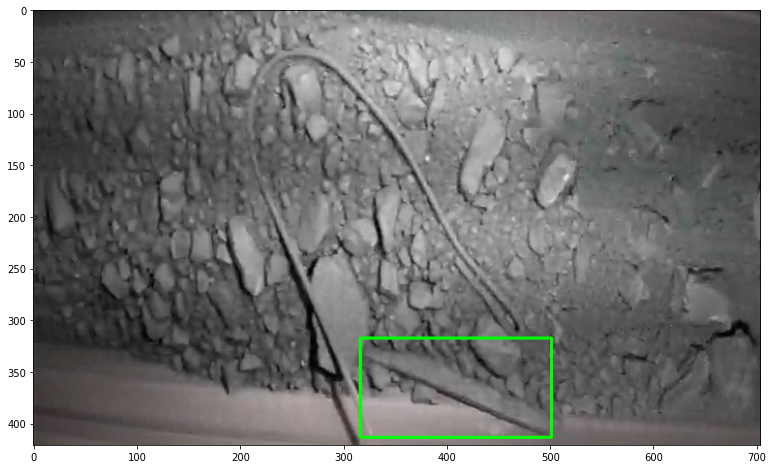

In [33]:
idx = 0
for i in range(idx, len(fdf)):
    if fdf.loc[i]["Image_name_Type"].split("_")[-1] == "wood":
        idx = i
        break
name = '_'.join(fdf.loc[idx]["Image_name_Type"].split("_")[:-1])
print(idx, name, fdf.loc[idx]["Image_name_Type"].split("_")[-1])
boxes = fdf.loc[idx].boxes
visualize(name, boxes)

0 0000Date_01_08_2019.jpg armature


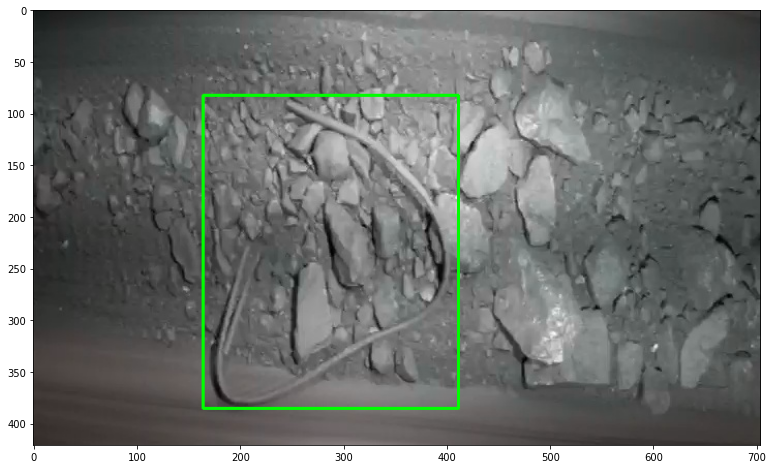

In [34]:
idx = 0
for i in range(idx, len(fdf)):
    if fdf.loc[i]["Image_name_Type"].split("_")[-1] == "armature":
        idx = i
        break
name = '_'.join(fdf.loc[idx]["Image_name_Type"].split("_")[:-1])
print(idx, name, fdf.loc[idx]["Image_name_Type"].split("_")[-1])
boxes = fdf.loc[idx].boxes
visualize(name, boxes)

146 10381Date_05_08_2019.jpg other


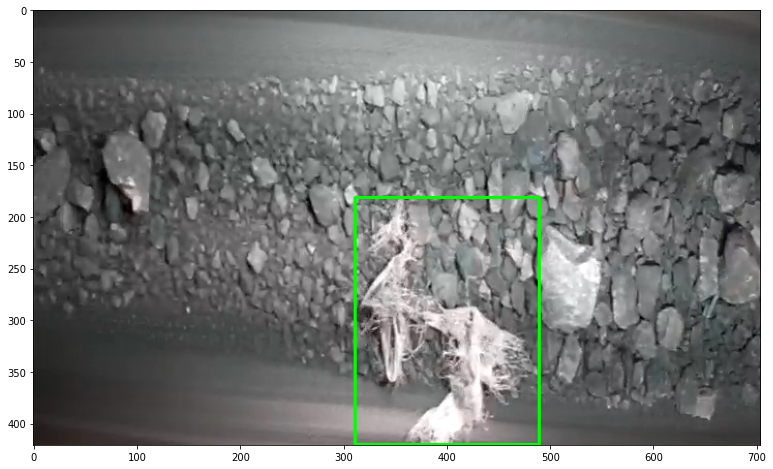

In [35]:
idx = 0
for i in range(idx, len(fdf)):
    if fdf.loc[i]["Image_name_Type"].split("_")[-1] == "other":
        idx = i
        break
name = '_'.join(fdf.loc[idx]["Image_name_Type"].split("_")[:-1])
print(idx, name, fdf.loc[idx]["Image_name_Type"].split("_")[-1])
boxes = fdf.loc[idx].boxes
visualize(name, boxes)

### Encode boxes and create submission

In [36]:
def EncodedPixels_string(pixels):
    EncodedPixels_s = ''
    x = 0
    w = 0
    for i in range(len(pixels)):
        if x==0:
            if pixels[i]==1:
                x = i
                w += 1
        else:
            if pixels[i]==1:
                w += 1
            else:
                EncodedPixels_s = EncodedPixels_s + str(x+1) + ' ' + str(w) + ' '
                x = 0
                w = 0
                
    return EncodedPixels_s


def EncodedPixels(data, x_shape=704, y_shape=421):
        
    image_pixels = np.zeros((x_shape, y_shape))
    
    for k in range(len(data)):
        xmin = int(data[k][0])
        ymin = int(data[k][1])
        xmax = int(data[k][2] + 1)
        ymax = int(data[k][3] + 1)
        image_pixels[xmin:xmax, ymin:ymax] = 1

    image_pixels = image_pixels.T.reshape(1, -1)[0]
    EncodedPixels_s = EncodedPixels_string(image_pixels)
    
    return EncodedPixels_s

In [37]:
submit_df['EncodedPixels'] = '1 1'
for i, row in tqdm(submit_df.iterrows(), total=len(submit_df)):
    if row['boxes'] == '1 1':
        continue
    image_name = IMAGES_PATH + "_".join(row["Image_name_Type"].split("_")[:-1])
    image = cv2.imread(image_name, cv2.COLOR_BGR2RGB)
    x_shape, y_shape = image.shape[1], image.shape[0]
    row['EncodedPixels'] = EncodedPixels(row["boxes"], x_shape, y_shape)
submit_df.drop(columns=["boxes"], inplace=True)

  0%|          | 0/4605 [00:00<?, ?it/s]

In [38]:
submit_df.to_csv("MaskRCNN_best_model_80_threshold.csv", index=False)